<a href="https://colab.research.google.com/github/arshmehar/ssh_Indian_Ocean/blob/main/hadgem_regridding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hadgem: regridding, masking and gap filling

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install cartopy netCDF4 cftime
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
import scipy.interpolate
import cartopy.feature as cfeature
import torch.optim as optim
import torch

In [ ]:
#aviso(target dataset)
aviso_ds = xr.open_dataset('/content/gdrive/MyDrive/prerna_data/AVISO/IO-AVISO_DSL_1993_2014-dsl.nc',engine="netcdf4")
aviso_ds

<xarray.Dataset> Size: 182MB
Dimensions:            (LONGITUDE841_1200: 360, LATITUDE241_480: 240,
                        TIME: 264, bnds: 2)
Coordinates:
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * TIME               (TIME) datetime64[ns] 2kB 1993-01-16 ... 2014-12-16
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds          (TIME, bnds) datetime64[ns] 4kB ...
    AVISODSL           (TIME, LATITUDE241_480, LONGITUDE841_1200) float64 182MB ...
Attributes:
    history:      FERRET V7.3 (optimized)  5-Jul-24
    Conventions:  CF-1.6

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


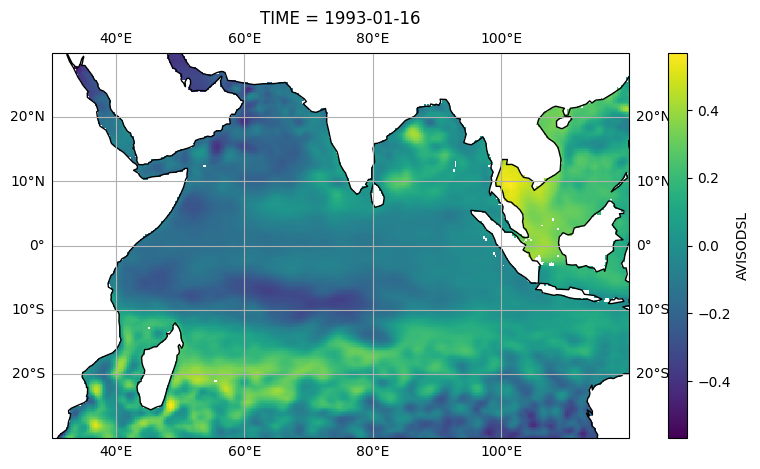

In [ ]:
data_var = aviso_ds['AVISODSL']

data = data_var.isel(TIME=0)  # Select first time step

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'AVISODSL'})
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

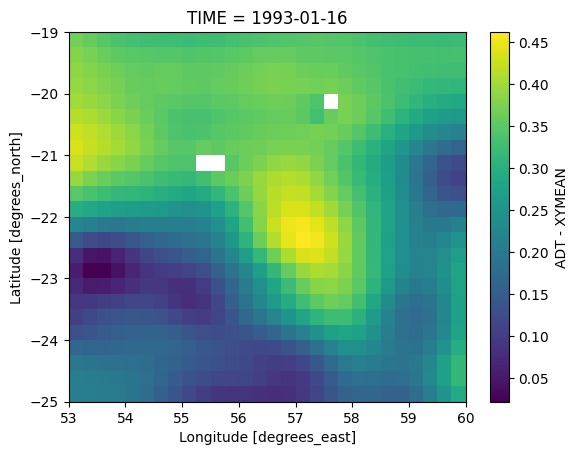

In [ ]:
aviso_ds['AVISODSL'].sel(LONGITUDE841_1200=slice(53,60)).sel(LATITUDE241_480=slice(-25,-19)).isel(TIME=0).plot()

In [ ]:
#grid resolution
lat_res = aviso_ds['LATITUDE241_480'].diff(dim='LATITUDE241_480').mean().item()
lon_res = aviso_ds['LONGITUDE841_1200'].diff(dim='LONGITUDE841_1200').mean().item()

print(f"Latitude resolution: {lat_res} degrees")
print(f"Longitude resolution: {lon_res} degrees")

Latitude resolution: 0.25 degrees
Longitude resolution: 0.25 degrees


In [ ]:
!ls /content/gdrive/MyDrive/prerna_data/nHadGem-LL

edit.sh  set_13  set_18  set_22  set_27  set_31  set_36  set_41  set_46  set_7
set_1	 set_14  set_19  set_23  set_28  set_32  set_37  set_42  set_47  set_8
set_10	 set_15  set_2	 set_24  set_29  set_33  set_39  set_43  set_48  set_9
set_11	 set_16  set_20  set_25  set_3	 set_34  set_4	 set_44  set_5	 template.nc
set_12	 set_17  set_21  set_26  set_30  set_35  set_40  set_45  set_6


In [ ]:
!ls /content/gdrive/MyDrive/prerna_data/nHadGem-LL/set_1

LL_HADGem_ensemble_1.nc


In [ ]:
ds = xr.open_dataset('/content/gdrive/MyDrive/prerna_data/nHadGem-LL/set_1/LL_HADGem_ensemble_1.nc')
ds

<xarray.Dataset> Size: 29MB
Dimensions:     (TIME: 264, LON21_126: 106, LAT101_230: 130)
Coordinates:
  * TIME        (TIME) object 2kB 1993-01-16 00:00:00 ... 2014-12-16 00:00:00
  * LON21_126   (LON21_126) float64 848B 20.0 21.0 22.0 ... 123.0 124.0 125.0
  * LAT101_230  (LAT101_230) float64 1kB -35.18 -34.64 -34.09 ... 34.64 35.18
Data variables:
    DSL         (TIME, LAT101_230, LON21_126) float64 29MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:57:05 2024: cdo selyear,1993/2014 dsl_1.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

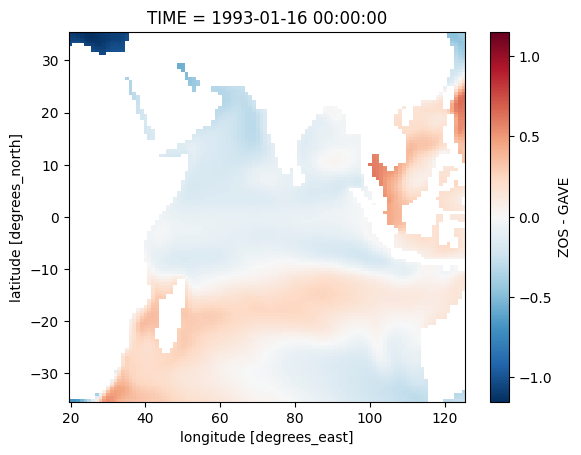

In [ ]:
ds.DSL.isel(TIME=0).plot()

In [ ]:
ds_interp = ds.interp(
    LAT101_230=aviso_ds.LATITUDE241_480.values,  # Interpolating along latitude
    LON21_126=aviso_ds.LONGITUDE841_1200.values,  # Interpolating along longitude
    method='linear'  # Linear interpolation
)
ds_interp

<xarray.Dataset> Size: 182MB
Dimensions:     (TIME: 264, LAT101_230: 240, LON21_126: 360)
Coordinates:
  * TIME        (TIME) object 2kB 1993-01-16 00:00:00 ... 2014-12-16 00:00:00
  * LAT101_230  (LAT101_230) float32 960B -29.88 -29.62 -29.38 ... 29.62 29.88
  * LON21_126   (LON21_126) float32 1kB 30.12 30.38 30.62 ... 119.4 119.6 119.9
Data variables:
    DSL         (TIME, LAT101_230, LON21_126) float64 182MB nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:57:05 2024: cdo selyear,1993/2014 dsl_1.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

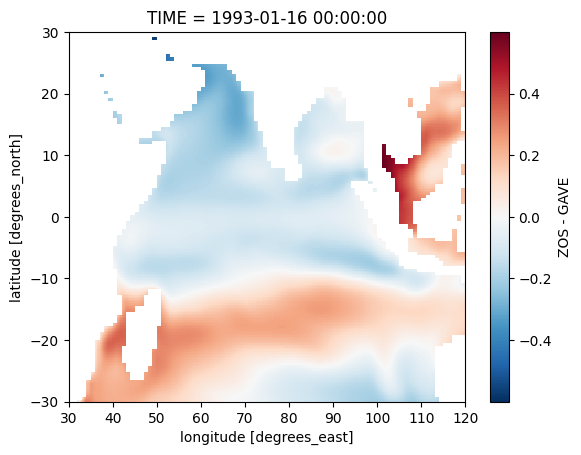

In [ ]:
ds_interp.DSL.isel(TIME=0).plot()

In [ ]:
ds_interp.DSL.isel(TIME=0).values.shape

(240, 360)

In [ ]:
aviso_ds.AVISODSL.isel(TIME=0).values.shape

(240, 360)

In [ ]:
mask_aviso = aviso_ds.AVISODSL.isel(TIME=0).values
mask_aviso = mask_aviso/mask_aviso
np.nansum(mask_aviso)

58241.0

In [ ]:
mask_hadgem = ds_interp.DSL.isel(TIME=0).values
mask_hadgem = mask_hadgem/mask_hadgem
np.nansum(mask_hadgem)

50800.0

In [ ]:
ds_interp_dsl_np = ds_interp.DSL.isel(TIME=0).values
ds_interp_dsl_np[np.isnan(mask_aviso)]=np.nan

In [ ]:
not(np.isnan(mask_aviso))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#hadgem
#accessing netcdf files
base_path = '/content/gdrive/MyDrive/prerna_data/nHadGem-LL'
ensembles = []

for setf in os.listdir(base_path):
    setf_path = os.path.join(base_path, setf)
    if os.path.isdir(setf_path):
        for file in os.listdir(setf_path):
            if file.endswith('.nc'):
                ensembles.append(os.path.join(setf_path, file))

print(f" {len(ensembles)} NetCDF files.")

 47 NetCDF files.


In [ ]:
datasets = []
for file in ensembles:
    ds = xr.open_dataset(file, decode_times=False)
    datasets.append(ds)
# Combine all datasets into one along  dimension ensemble_member
combined_ds = xr.concat(datasets, dim='ensemble_member')

print(combined_ds)

<xarray.Dataset> Size: 1GB
Dimensions:     (ensemble_member: 47, TIME: 264, LAT101_230: 130, LON21_126: 106)
Coordinates:
  * TIME        (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.936e+04 5.938e+04
  * LON21_126   (LON21_126) float64 848B 20.0 21.0 22.0 ... 123.0 124.0 125.0
  * LAT101_230  (LAT101_230) float64 1kB -35.18 -34.64 -34.09 ... 34.64 35.18
Dimensions without coordinates: ensemble_member
Data variables:
    DSL         (ensemble_member, TIME, LAT101_230, LON21_126) float64 1GB -0...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


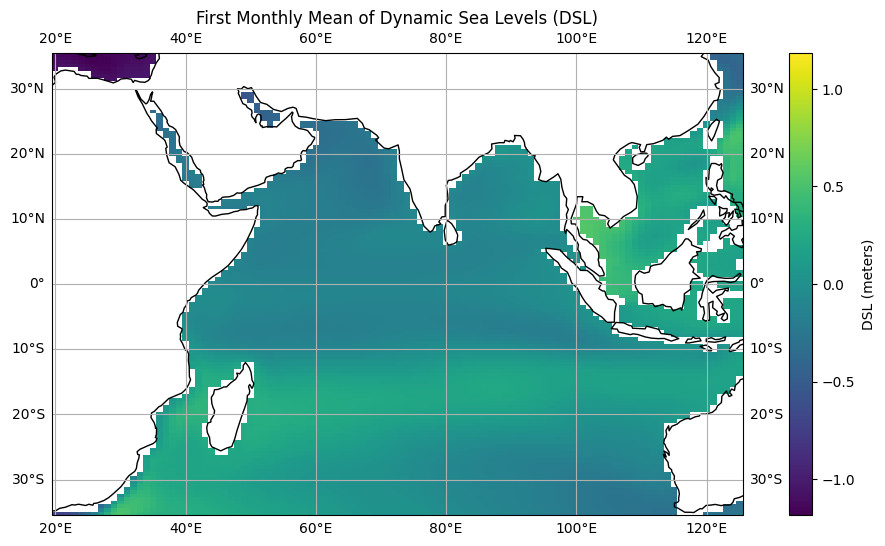

In [ ]:
avg_across_members = combined_ds['DSL'].mean(dim='ensemble_member')
first_month = avg_across_members.isel(TIME=0)
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            cbar_kwargs={'label': 'DSL (meters)'})
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("First Monthly Mean of Dynamic Sea Levels (DSL)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
lat_res = combined_ds['LAT101_230'].diff(dim='LAT101_230').mean().item()
lon_res = combined_ds['LON21_126'].diff(dim='LON21_126').mean().item()

print(f"Latitude resolution: {lat_res} degrees")
print(f"Longitude resolution: {lon_res} degrees")

Latitude resolution: 0.5454545454545455 degrees
Longitude resolution: 1.0 degrees


In [ ]:
# Inspect dataset
print(combined_ds)
print(combined_ds['DSL'].isnull().sum())

def fill_nan_interpolation(data, lons, lats):
    # Flatten the arrays for interpolation
    lons_flat, lats_flat = np.meshgrid(lons, lats)
    lons_flat = lons_flat.flatten()
    lats_flat = lats_flat.flatten()
    data_flat = data.flatten()

    # Create mask for NaNs
    mask = ~np.isnan(data_flat)

    # Extract non-NaN values and their coordinates
    data_masked = data_flat[mask]
    lons_masked = lons_flat[mask]
    lats_masked = lats_flat[mask]

    # Perform nearest-neighbor interpolation
    interp = scipy.interpolate.NearestNDInterpolator(
        (lons_masked, lats_masked), data_masked
    )

    # Interpolate NaN locations
    filled_data = interp(lons_flat, lats_flat).reshape(data.shape)

    return filled_data

<xarray.Dataset> Size: 1GB
Dimensions:     (ensemble_member: 47, TIME: 264, LAT101_230: 130, LON21_126: 106)
Coordinates:
  * TIME        (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.936e+04 5.938e+04
  * LON21_126   (LON21_126) float64 848B 20.0 21.0 22.0 ... 123.0 124.0 125.0
  * LAT101_230  (LAT101_230) float64 1kB -35.18 -34.64 -34.09 ... 34.64 35.18
Dimensions without coordinates: ensemble_member
Data variables:
    DSL         (ensemble_member, TIME, LAT101_230, LON21_126) float64 1GB -0...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
<xarray.DataArray 'DSL' ()> Size: 8B
array(77587224)


In [ ]:
filled_ds = combined_ds.copy(deep=True)


for ens in range(combined_ds.sizes['ensemble_member']):
    for t in range(combined_ds.sizes['TIME']):
        # Extract the current data slice
        original_vals = combined_ds['DSL'].isel(ensemble_member=ens, TIME=t).values
        original_lons = combined_ds['LON21_126'].values
        original_lats = combined_ds['LAT101_230'].values

        # Fill NaNs
        filled_vals = fill_nan_interpolation(original_vals, original_lons, original_lats)

        # Update the dataset with filled values
        filled_ds['DSL'].isel(ensemble_member=ens, TIME=t).values[:] = filled_vals



In [ ]:
# Inspect the filled dataset
print(filled_ds)
print(filled_ds['DSL'].isnull().sum())


<xarray.Dataset> Size: 1GB
Dimensions:     (ensemble_member: 47, TIME: 264, LAT101_230: 130, LON21_126: 106)
Coordinates:
  * TIME        (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.936e+04 5.938e+04
  * LON21_126   (LON21_126) float64 848B 20.0 21.0 22.0 ... 123.0 124.0 125.0
  * LAT101_230  (LAT101_230) float64 1kB -35.18 -34.64 -34.09 ... 34.64 35.18
Dimensions without coordinates: ensemble_member
Data variables:
    DSL         (ensemble_member, TIME, LAT101_230, LON21_126) float64 1GB -0...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
<xarray.DataArray 'DSL' ()> Size: 8B
array(0)


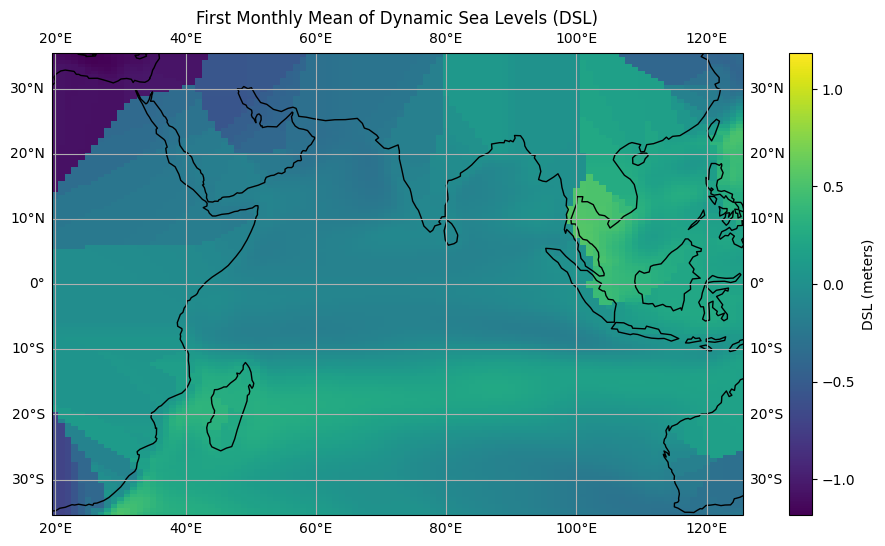

In [ ]:
avg_across_members = filled_ds['DSL'].mean(dim='ensemble_member')
first_month = avg_across_members.isel(TIME=0)
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            cbar_kwargs={'label': 'DSL (meters)'})
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("First Monthly Mean of Dynamic Sea Levels (DSL)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
print("NaNs in combined_ds['DSL']:", combined_ds['DSL'].isnull().sum())
print("NaNs in filled_ds['DSL']:", filled_ds['DSL'].isnull().sum())

NaNs in combined_ds['DSL']: <xarray.DataArray 'DSL' ()> Size: 8B
array(77587224)
NaNs in filled_ds['DSL']: <xarray.DataArray 'DSL' ()> Size: 8B
array(0)


In [ ]:
#regridding hadgem
targ_lat=aviso_ds['LATITUDE241_480'].values
targ_lon=aviso_ds['LONGITUDE841_1200'].values
target_grid = xr.Dataset({
    'LAT101_230': (['LAT101_230'], targ_lat),
    'LON21_126': (['LON21_126'], targ_lon)})

In [ ]:
# interpolation

file_paths = []

output_dir = 'output_regridded'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

for i in range(len(filled_ds['ensemble_member'])):
    data = filled_ds.sel(ensemble_member=i)

    # Interpolate to the target grid using linear method
    regrid_hadgem = data.interp(
        LAT101_230=target_grid.LAT101_230,
        LON21_126=target_grid.LON21_126,
        method='linear'
    )



    # Save the regridded dataset to a NetCDF file
    file_path = os.path.join(output_dir, f'filled_regridded_member_{i}.nc')
    regrid_hadgem.to_netcdf(file_path)
    file_paths.append(file_path)

    # Clear data from memory
    del regrid_hadgem
    del data

# Combine all regridded datasets into one
combined_regridded = xr.open_mfdataset(file_paths, combine='nested', concat_dim='ensemble_member')
print(combined_regridded)

<xarray.Dataset> Size: 9GB
Dimensions:     (ensemble_member: 47, TIME: 264, LAT101_230: 240, LON21_126: 360)
Coordinates:
  * TIME        (TIME) object 2kB 1993-01-16 00:00:00 ... 2014-12-16 00:00:00
  * LAT101_230  (LAT101_230) float32 960B -29.88 -29.62 -29.38 ... 29.62 29.88
  * LON21_126   (LON21_126) float32 1kB 30.12 30.38 30.62 ... 119.4 119.6 119.9
Dimensions without coordinates: ensemble_member
Data variables:
    DSL         (ensemble_member, TIME, LAT101_230, LON21_126) float64 9GB dask.array<chunksize=(1, 1, 240, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


In [ ]:
hadgem_dsr = combined_regridded.rename({
    'LAT101_230': 'LATITUDE241_480',
    'LON21_126': 'LONGITUDE841_1200'
})


print("Renamed Coordinates in Combined_ds:")
print(hadgem_dsr)

Renamed Coordinates in Combined_ds:
<xarray.Dataset> Size: 9GB
Dimensions:            (ensemble_member: 47, TIME: 264, LATITUDE241_480: 240,
                        LONGITUDE841_1200: 360)
Coordinates:
  * TIME               (TIME) object 2kB 1993-01-16 00:00:00 ... 2014-12-16 0...
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
Dimensions without coordinates: ensemble_member
Data variables:
    DSL                (ensemble_member, TIME, LATITUDE241_480, LONGITUDE841_1200) float64 9GB dask.array<chunksize=(1, 1, 240, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


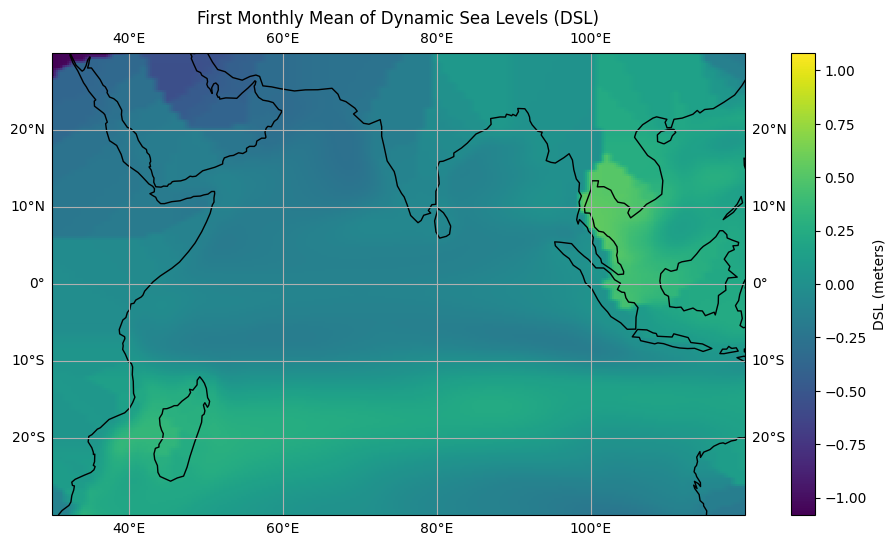

In [ ]:
avg_across_members = hadgem_dsr['DSL'].mean(dim='ensemble_member')
first_month = avg_across_members.isel(TIME=0)
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            cbar_kwargs={'label': 'DSL (meters)'})
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("First Monthly Mean of Dynamic Sea Levels (DSL)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
mask = aviso_ds['AVISODSL'].isel(TIME=0).values
mask = mask/mask
mask

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
mask_da = xr.DataArray(
    mask,
    dims=['LATITUDE241_480', 'LONGITUDE841_1200'],
    coords={
        'LATITUDE241_480': hadgem_dsr['LATITUDE241_480'],
        'LONGITUDE841_1200': hadgem_dsr['LONGITUDE841_1200']})
hadgem_dsr['DSL'] = hadgem_dsr['DSL'] * mask_da

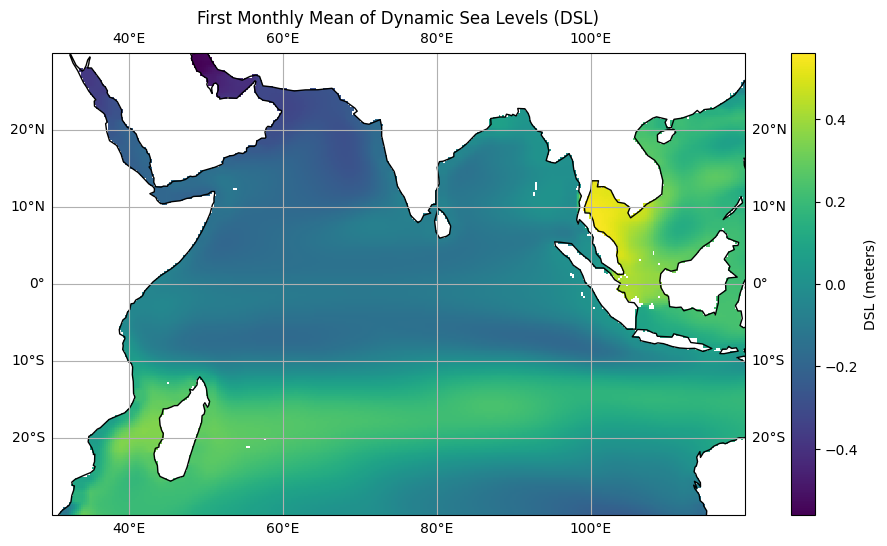

In [ ]:
avg_across_members = hadgem_dsr['DSL'].mean(dim='ensemble_member')
first_month = avg_across_members.isel(TIME=0)
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            cbar_kwargs={'label': 'DSL (meters)'})
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("First Monthly Mean of Dynamic Sea Levels (DSL)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
np.nansum(mask)#aviso nan

58241.0

In [ ]:
mask_hadgem = hadgem_dsr.DSL.isel(TIME=0).values
mask_hadgem = mask_hadgem/mask_hadgem
np.nansum(mask_hadgem/47)#for 1 ensemble

58240.99999999999

<xarray.Dataset> Size: 9GB
Dimensions:            (ensemble_member: 47, TIME: 264, LATITUDE241_480: 240,
                        LONGITUDE841_1200: 360)
Coordinates:
  * TIME               (TIME) object 2kB 1993-01-16 00:00:00 ... 2014-12-16 0...
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
Dimensions without coordinates: ensemble_member
Data variables:
    DSL                (ensemble_member, TIME, LATITUDE241_480, LONGITUDE841_1200) float64 9GB dask.array<chunksize=(1, 1, 240, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [ ]:
#accessing hadgem
base_path = '/content/gdrive/MyDrive/prerna_data/regrid_hadgem'


ensembles = []


for setf in os.listdir(base_path):
    setf_path = os.path.join(base_path, setf)
    if os.path.isdir(setf_path):
        for file in os.listdir(setf_path):
            if file.endswith('.nc'):
                ensembles.append(os.path.join(setf_path, file))

print(f"Found {len(ensembles)} NetCDF files.")


datasets = []

# Load datasets using Dask's lazy loading (chunks set to handle large datasets)
for file in ensembles:
    ds = xr.open_dataset(file, decode_times=False, chunks={'ensemble_member': 1})
    datasets.append(ds)


hadgem_ds = xr.concat(datasets, dim='ensemble_member')

print(hadgem_ds)


Found 47 NetCDF files.
<xarray.Dataset> Size: 9GB
Dimensions:            (ensemble_member: 47, TIME: 264, LATITUDE241_480: 240,
                        LONGITUDE841_1200: 360)
Coordinates:
  * TIME               (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.938e+04
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
Dimensions without coordinates: ensemble_member
Data variables:
    DSL                (ensemble_member, TIME, LATITUDE241_480, LONGITUDE841_1200) float64 9GB dask.array<chunksize=(1, 1, 240, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


In [ ]:
hadgem_ds

<xarray.Dataset> Size: 9GB
Dimensions:            (ensemble_member: 47, TIME: 264, LATITUDE241_480: 240,
                        LONGITUDE841_1200: 360)
Coordinates:
  * TIME               (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.938e+04
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
Dimensions without coordinates: ensemble_member
Data variables:
    DSL                (ensemble_member, TIME, LATITUDE241_480, LONGITUDE841_1200) float64 9GB dask.array<chunksize=(1, 1, 240, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [ ]:
aviso_ds

<xarray.Dataset> Size: 182MB
Dimensions:            (LONGITUDE841_1200: 360, LATITUDE241_480: 240,
                        TIME: 264, bnds: 2)
Coordinates:
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * TIME               (TIME) datetime64[ns] 2kB 1993-01-16 ... 2014-12-16
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds          (TIME, bnds) datetime64[ns] 4kB ...
    AVISODSL           (TIME, LATITUDE241_480, LONGITUDE841_1200) float64 182MB ...
Attributes:
    history:      FERRET V7.3 (optimized)  5-Jul-24
    Conventions:  CF-1.6

In [ ]:
hadgem_ds['avisodsl'] = (('TIME', 'LATITUDE241_480', 'LONGITUDE841_1200'), aviso_ds.AVISODSL.values)
hadgem_ds

<xarray.Dataset> Size: 9GB
Dimensions:            (ensemble_member: 47, TIME: 264, LATITUDE241_480: 240,
                        LONGITUDE841_1200: 360)
Coordinates:
  * TIME               (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.938e+04
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
Dimensions without coordinates: ensemble_member
Data variables:
    DSL                (ensemble_member, TIME, LATITUDE241_480, LONGITUDE841_1200) float64 9GB dask.array<chunksize=(1, 1, 240, 360), meta=np.ndarray>
    avisodsl           (TIME, LATITUDE241_480, LONGITUDE841_1200) float64 182MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

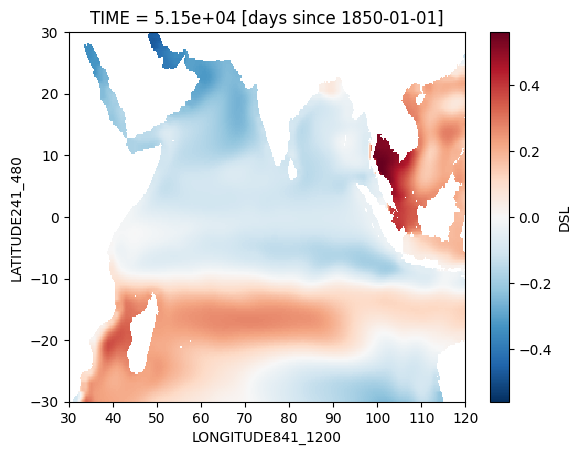

In [ ]:
hadgem_ds.DSL.isel(ensemble_member=0).isel(TIME=0).plot()

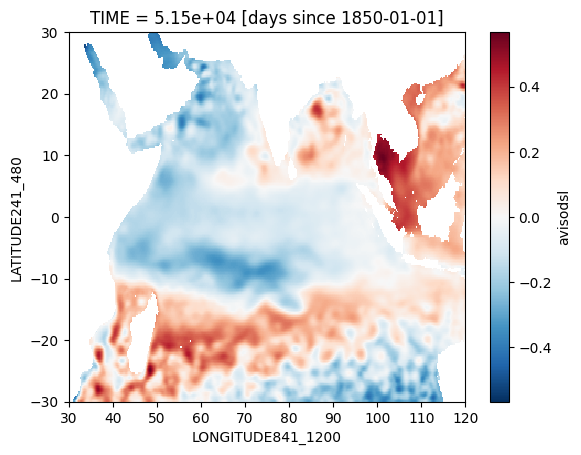

In [ ]:
hadgem_ds.avisodsl.isel(TIME=0).plot()

In [ ]:
hadgem_ds.to_netcdf('/content/gdrive/MyDrive/prerna_data/hadgem_aviso.nc')

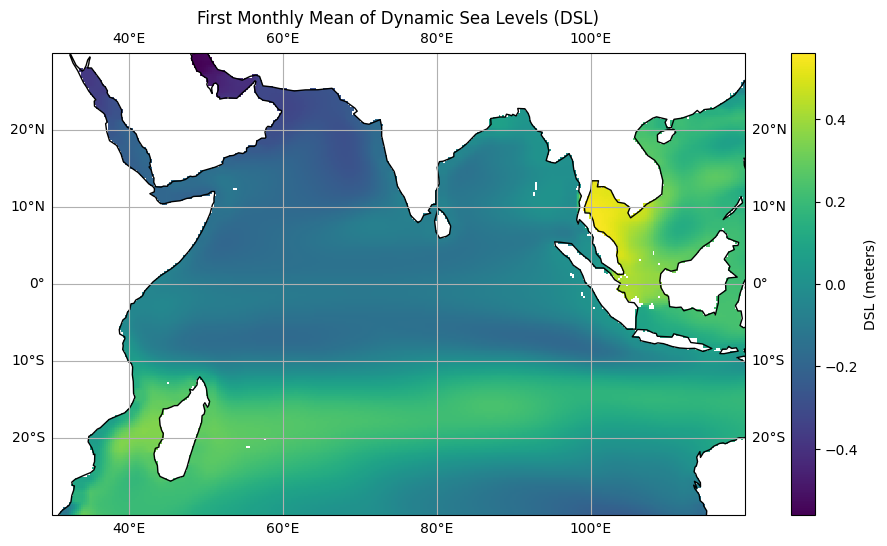

In [ ]:
avg_across_members = hadgem_ds['DSL'].mean(dim='ensemble_member')
first_month = avg_across_members.isel(TIME=0)
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            cbar_kwargs={'label': 'DSL (meters)'})
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("First Monthly Mean of Dynamic Sea Levels (DSL)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()